In [1]:
# --- Imports & Setup ---

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Explainability
import shap


In [5]:
data = pd.read_csv('Downloads/WA_Fn-UseC_-HR-Employee-Attrition.csv')
# Preview
print("Shape:", data.shape)
data.head(3)


Shape: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0


In [7]:
# Clean column names to snake_case and create a numeric target

data = data.copy()

def to_snake(s):
    return (s.strip()
              .replace('-', '_')
              .replace(' ', '_')
              .replace('/', '_')
              .replace('(', '')
              .replace(')', '')
              .lower())

data.columns = [to_snake(c) for c in data.columns]

# target: 1 = "Yes", 0 = "No"
data['attrition_flag'] = (data['attrition'].astype(str).str.strip().str.lower() == 'yes').astype(int)

# drop obvious ID/leakage columns if present
to_drop = ['employee_number', 'over18', 'standard_hours', 'employee_count']
data = data[[c for c in data.columns if c not in to_drop]]

print("Shape after clean:", data.shape)
data.head(3)


Shape after clean: (1470, 35)


,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,employeecount,employeenumber,...,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition_flag
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,80,0,8,0,1,6,4,0,5,1
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,80,1,10,3,3,10,7,1,7,0
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,80,0,7,3,3,0,0,0,0,1


In [9]:
data['attrition'].value_counts()
(data['attrition_flag'].value_counts(normalize=True) * 100).round(1)
data.isna().sum().sort_values(ascending=False).head(10)


age                         0
stockoptionlevel            0
numcompaniesworked          0
overtime                    0
percentsalaryhike           0
performancerating           0
relationshipsatisfaction    0
standardhours               0
totalworkingyears           0
monthlyincome               0
dtype: int64

In [11]:
data.info()
data.columns.tolist()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   age                       1470 non-null   int64 
 1   attrition                 1470 non-null   object
 2   businesstravel            1470 non-null   object
 3   dailyrate                 1470 non-null   int64 
 4   department                1470 non-null   object
 5   distancefromhome          1470 non-null   int64 
 6   education                 1470 non-null   int64 
 7   educationfield            1470 non-null   object
 8   employeecount             1470 non-null   int64 
 9   employeenumber            1470 non-null   int64 
 10  environmentsatisfaction   1470 non-null   int64 
 11  gender                    1470 non-null   object
 12  hourlyrate                1470 non-null   int64 
 13  jobinvolvement            1470 non-null   int64 
 14  joblevel                

['age',
 'attrition',
 'businesstravel',
 'dailyrate',
 'department',
 'distancefromhome',
 'education',
 'educationfield',
 'employeecount',
 'employeenumber',
 'environmentsatisfaction',
 'gender',
 'hourlyrate',
 'jobinvolvement',
 'joblevel',
 'jobrole',
 'jobsatisfaction',
 'maritalstatus',
 'monthlyincome',
 'monthlyrate',
 'numcompaniesworked',
 'overtime',
 'percentsalaryhike',
 'performancerating',
 'relationshipsatisfaction',
 'standardhours',
 'stockoptionlevel',
 'totalworkingyears',
 'trainingtimeslastyear',
 'worklifebalance',
 'yearsatcompany',
 'yearsincurrentrole',
 'yearssincelastpromotion',
 'yearswithcurrmanager',
 'attrition_flag']

In [15]:
# Count of people who left vs stayed
print(data['attrition'].value_counts())

# Percentage who left
print((data['attrition_flag'].value_counts(normalize=True) * 100).round(1))

# Average age and income by attrition group
data.groupby('attrition')[['age', 'monthlyincome']].mean()


attrition
No     1233
Yes     237
Name: count, dtype: int64
attrition_flag
0    83.9
1    16.1
Name: proportion, dtype: float64


,age,monthlyincome
attrition,,
No,37.561233,6832.739659
Yes,33.607595,4787.092827


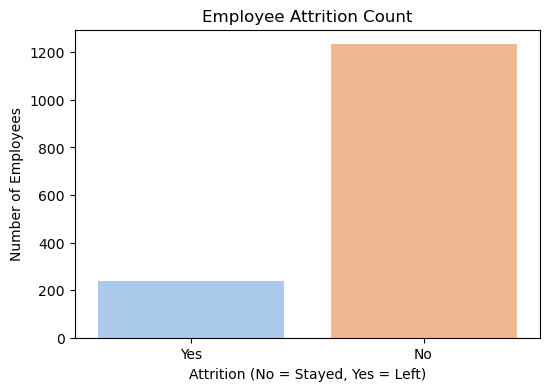

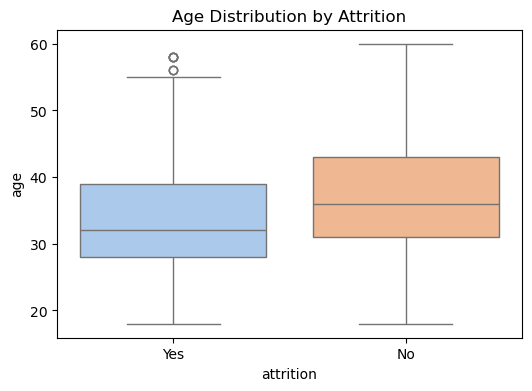

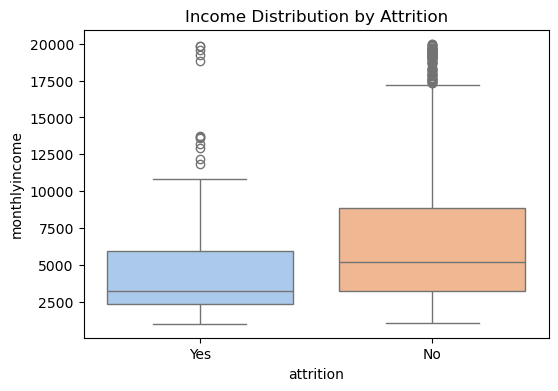

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Count plot
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='attrition', hue='attrition', palette='pastel', legend=False)
plt.title('Employee Attrition Count')
plt.xlabel('Attrition (No = Stayed, Yes = Left)')
plt.ylabel('Number of Employees')
plt.show()

# 2. Age boxplot
plt.figure(figsize=(6,4))
sns.boxplot(data=data, x='attrition', y='age', hue='attrition', palette='pastel', legend=False)
plt.title('Age Distribution by Attrition')
plt.show()

# 3. Income boxplot
plt.figure(figsize=(6,4))
sns.boxplot(data=data, x='attrition', y='monthlyincome', hue='attrition', palette='pastel', legend=False)
plt.title('Income Distribution by Attrition')
plt.show()


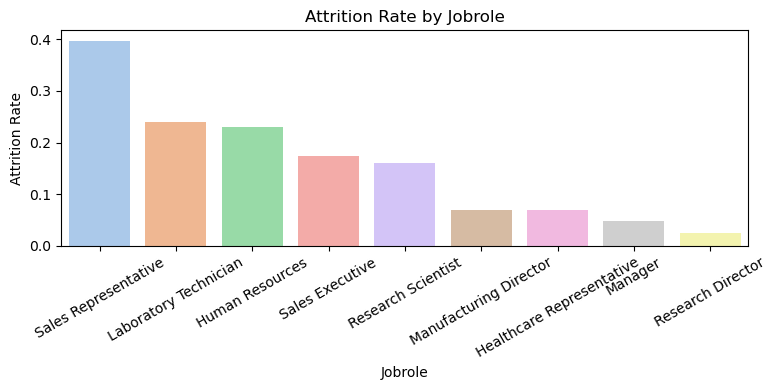

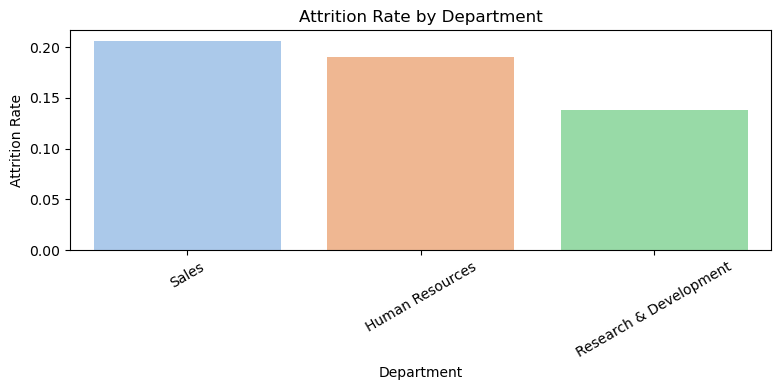

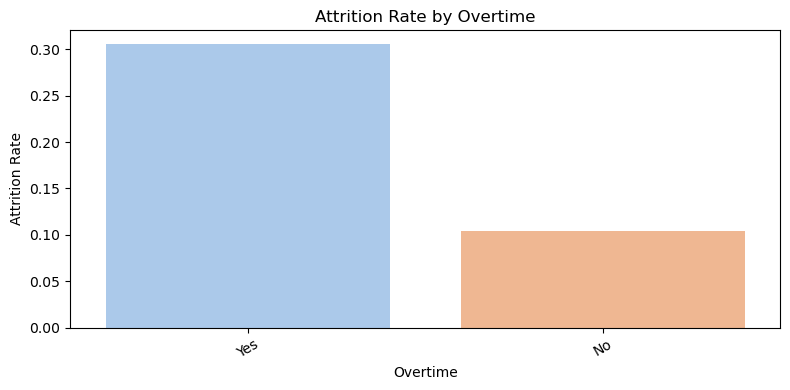

In [23]:
def plot_attrition_rate(feature):
    plt.figure(figsize=(8,4))
    rate = data.groupby(feature)['attrition_flag'].mean().sort_values(ascending=False).reset_index()

    sns.barplot(data=rate, x=feature, y='attrition_flag', hue=feature,
                palette='pastel', legend=False)
    
    plt.title(f'Attrition Rate by {feature.capitalize()}')
    plt.ylabel('Attrition Rate')
    plt.xlabel(feature.capitalize())
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()
plot_attrition_rate('jobrole')
plot_attrition_rate('department')
plot_attrition_rate('overtime')


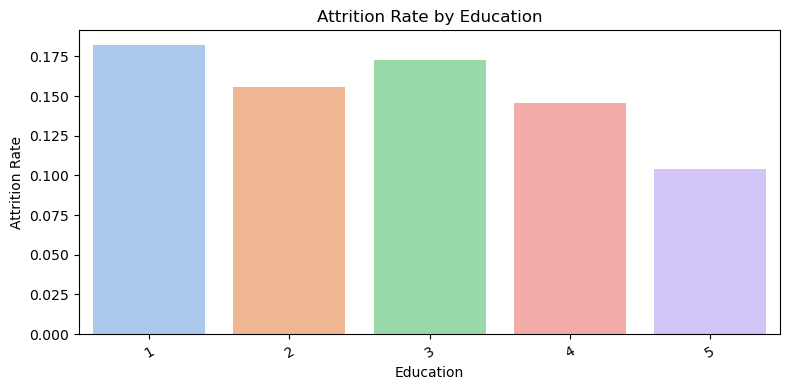

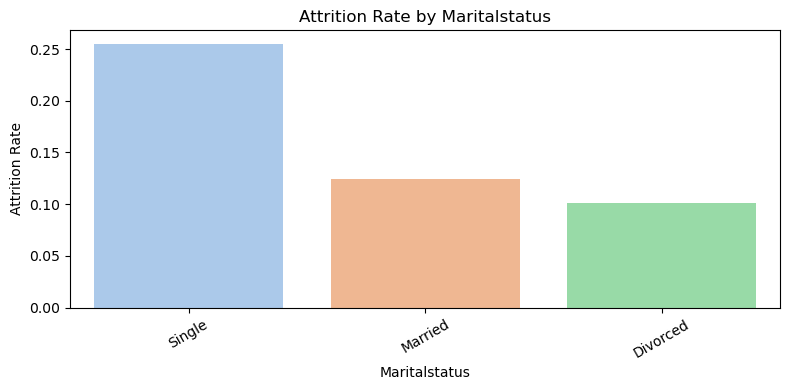

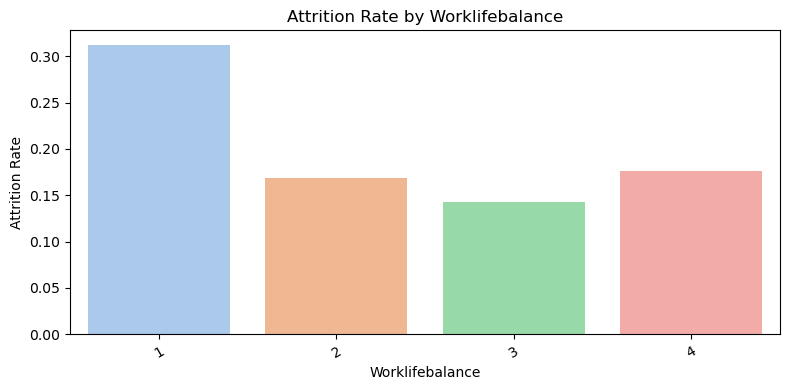

In [25]:
# More categorical features to explore
plot_attrition_rate('education')
plot_attrition_rate('maritalstatus')
plot_attrition_rate('worklifebalance')

In [27]:
# Separate the target (what we want to predict)
target = 'attrition_flag'

# Choose a few key features for a simple baseline model
features = ['age', 'monthlyincome', 'overtime', 'jobrole', 'maritalstatus', 'worklifebalance']

X = data[features]
y = data[target]


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

X_train.shape, X_test.shape


((1102, 6), (368, 6))

              precision    recall  f1-score   support

           0      0.860     0.974     0.914       309
           1      0.556     0.169     0.260        59

    accuracy                          0.845       368
   macro avg      0.708     0.572     0.587       368
weighted avg      0.811     0.845     0.809       368

ROC AUC: 0.734


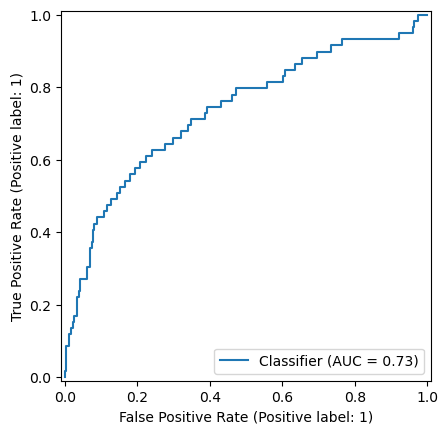

In [31]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay

# Identify which columns are numeric vs categorical
num_cols = ['age', 'monthlyincome', 'worklifebalance']
cat_cols = ['overtime', 'jobrole', 'maritalstatus']

# Preprocessing: scale numeric data and one-hot encode categorical
preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

# Logistic Regression model inside a pipeline
log_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('log_reg', LogisticRegression(max_iter=300))
])

# Train the model
log_model.fit(X_train, y_train)

# Predict on test data
preds = log_model.predict(X_test)
probs = log_model.predict_proba(X_test)[:, 1]

# Evaluate
print(classification_report(y_test, preds, digits=3))
print("ROC AUC:", roc_auc_score(y_test, probs).round(3))

RocCurveDisplay.from_predictions(y_test, probs)


In [33]:
# Extract model coefficients after preprocessing
model = log_model.named_steps['log_reg']
encoder = log_model.named_steps['preprocess']

# Get encoded feature names
num_features = num_cols
cat_features = log_model.named_steps['preprocess'].named_transformers_['cat'].get_feature_names_out(cat_cols)
all_features = np.concatenate([num_features, cat_features])

# Create a readable dataframe
coef_table = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient', ascending=False)

coef_table.head(15)


,Feature,Coefficient
13,jobrole_Sales Representative,1.169306
6,jobrole_Human Resources,0.789213
4,overtime_Yes,0.736012
7,jobrole_Laboratory Technician,0.689282
16,maritalstatus_Single,0.647298
12,jobrole_Sales Executive,0.416928
1,monthlyincome,-0.101815
8,jobrole_Manager,-0.202603
2,worklifebalance,-0.262565
15,maritalstatus_Married,-0.321301


              precision    recall  f1-score   support

           0      0.914     0.722     0.807       309
           1      0.306     0.644     0.415        59

    accuracy                          0.709       368
   macro avg      0.610     0.683     0.611       368
weighted avg      0.817     0.709     0.744       368

ROC AUC: 0.738


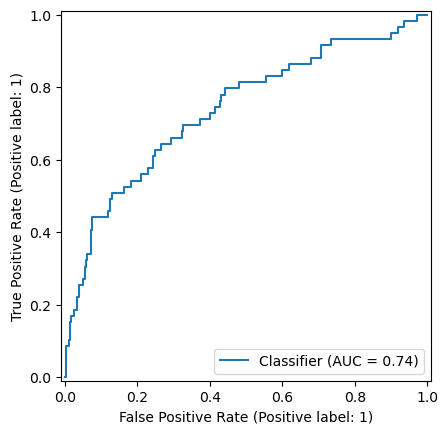

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay

# Build a weighted logistic regression pipeline
weighted_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('log_reg', LogisticRegression(max_iter=300, class_weight='balanced'))
])

# Train the new model
weighted_model.fit(X_train, y_train)

# Predict and evaluate
preds_w = weighted_model.predict(X_test)
probs_w = weighted_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, preds_w, digits=3))
print("ROC AUC:", roc_auc_score(y_test, probs_w).round(3))

RocCurveDisplay.from_predictions(y_test, probs_w)


              precision    recall  f1-score   support

           0      0.868     0.961     0.912       309
           1      0.538     0.237     0.329        59

    accuracy                          0.845       368
   macro avg      0.703     0.599     0.621       368
weighted avg      0.816     0.845     0.819       368

ROC AUC: 0.693


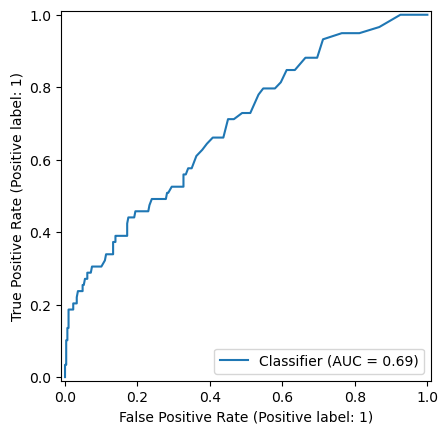

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay

# Random Forest inside same preprocessing pipeline
rf_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('rf', RandomForestClassifier(
        n_estimators=300,       # number of trees
        random_state=42,
        class_weight='balanced',  # handle imbalance
        max_depth=None,          # let trees grow freely
        n_jobs=-1                # use all cores
    ))
])

# Train and evaluate
rf_model.fit(X_train, y_train)

preds_rf = rf_model.predict(X_test)
probs_rf = rf_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, preds_rf, digits=3))
print("ROC AUC:", roc_auc_score(y_test, probs_rf).round(3))

RocCurveDisplay.from_predictions(y_test, probs_rf)


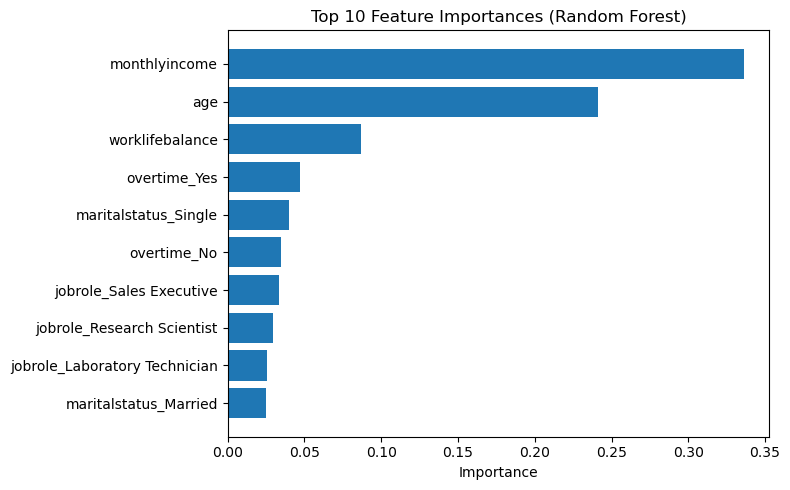

,Feature,Importance
1,monthlyincome,0.335972
0,age,0.241475
2,worklifebalance,0.086808
4,overtime_Yes,0.047203
16,maritalstatus_Single,0.040186
3,overtime_No,0.035016
12,jobrole_Sales Executive,0.033390
11,jobrole_Research Scientist,0.029532
7,jobrole_Laboratory Technician,0.025548
15,maritalstatus_Married,0.025012


In [41]:


# Get the trained forest
rf = rf_model.named_steps['rf']

# Get feature names after preprocessing
encoded_features = np.concatenate([
    num_cols,
    rf_model.named_steps['preprocess'].named_transformers_['cat'].get_feature_names_out(cat_cols)
])

# Create importance table
importance = pd.DataFrame({
    'Feature': encoded_features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(8,5))
plt.barh(importance['Feature'][:10][::-1], importance['Importance'][:10][::-1])
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

importance.head(10)


In [43]:
pip install nbconvert


Note: you may need to restart the kernel to use updated packages.
